## Part 2. Movie Lens - Non-Negative Matrix Factorization
MovieLens Rating Prediction using Non-negative Matrix Factorization.

I will use the RecSys class from week 3, to construct the rating matrix, and to encode user Ids and movie Ids. I will modify the fit method with Sklearn NMF model, and also modify the predict method accordingly. The predict_all method in RecSys class will make prediction for the test data.


### Sklearn Non-Negative Matrix Factorization (NMF)
Approximate the non-negative matrix X with a product of two non-negative matrices, i.e. matrices with all non-negative elements (W, H). 

Note: This model is suitable for data with non-negative entries, but not suitable for sparse data. It's well-suited for image or audio data that is typically dense.


### NMF Hyperparameter
As mentioned in the lecture on NMF, the non-negative matrix X is approximated by the product of 2 matrices W and H.
* If we assumed random variable $X_{i,j}$ follows a Gaussian Distribution, then we get the L2 loss (squared loss).
* If we assumed random variable $X_{i,j}$ follows a Laplace Distribution, then we get the L1 loss.

If $x_{i,j}$ is close to zero, their errors can be $\pm \; \varepsilon \text{~} N(0, \sigma)$ for L2 loss. Same thing with L1 loss, it may lead to a negative result. This can be a problem since our data is very sparse. The Document Term Matrix output from TfidfVectorizer has 99% sparsity. 

KL ('kullback-leibler') loss can be obtained by modeling our random variable to be Poisson Distribution. This is more suitable for our sparse data.

Note: solver 'cd' does not handle beta_loss = 'kullback-leibler', so we will use 'mu', Multiplicative Update solver.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csr_matrix
from scipy.linalg import svd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
MV_users = pd.read_csv('data/users.csv')
MV_movies = pd.read_csv('data/movies.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [158]:
from collections import namedtuple
Data = namedtuple('Data', ['users','movies','train','test'])
data = Data(MV_users, MV_movies, train, test)

In [4]:
data.users.head()

,uID,gender,age,accupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [5]:
data.movies.head()

,mID,title,year,Doc,Com,Hor,Adv,Wes,Dra,Ani,...,Chi,Cri,Thr,Sci,Mys,Rom,Fil,Fan,Act,Mus
0,1,Toy Story,1995,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,Grumpier Old Men,1995,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data.train.head()

,uID,mID,rating
0,744,1210,5
1,3040,1584,4
2,1451,1293,5
3,5455,3176,2
4,2507,3074,5


In [7]:
data.test.head()

,uID,mID,rating
0,2233,440,4
1,4274,587,5
2,2498,454,3
3,2868,2336,5
4,1636,2686,5


In [160]:
class RecSys():
    def __init__(self, data):
        self.data = data
        self.allusers = list(self.data.users['uID'])
        self.allmovies = list(self.data.movies['mID'])
        self.mid2idx = dict(zip(self.data.movies.mID, list(range(len(self.data.movies)))))
        self.uid2idx = dict(zip(self.data.users.uID, list(range(len(self.data.users)))))
        self.R = self.rating_matrix()
        
        # non-negative matrix W represents the basis vectors
        # it is obtained from nmf model transform method
        self.W = None
        
        # non-negative matrix H represents the weights that combine the basis vectors
        # to reconstruct the original rating matrix R. It is obtained from nmf model components_ method
        self.H = None
        
        # this will hold our predictions, obtained by the dot product of matrix W and matrix H
        self.R_hat = np.zeros((len(self.allusers), len(self.allmovies)))
        
        
    def rating_matrix(self):
        """
        Convert data.train (uID, mID, rating) to numpy array of shape (n_users, n_movies)
        """
        ind_movie = [self.mid2idx[x] for x in self.data.train.mID] 
        ind_user = [self.uid2idx[x] for x in self.data.train.uID]
        rating_train = list(self.data.train.rating)
        return coo_matrix((rating_train, (ind_user, ind_movie)), shape=(len(self.allusers), len(self.allmovies)))
    
    
    def fit(self, n_components=18, alpha_W=0, alpha_H=0, beta_loss='kullback-leibler', solver='mu', init='nndsvda'):
        start = time.time()
        print('Fitting NMF model ...')
        model = NMF(n_components=n_components, alpha_W=alpha_W, alpha_H=alpha_H, beta_loss=beta_loss, 
                    solver=solver, init=init, random_state=42, max_iter=1000)
        self.W = model.fit_transform(self.R)
        self.H = model.components_
        self.R_hat = np.dot(self.W, self.H)
        
        elapsed_time = (time.time() - start)/60
        print('NMF model evaluation in: {} minutes'.format(round(elapsed_time, 2)))
    
    
    def predict(self, uid, mid):
        """
        Get rating prediction of input params uid, mid from the rating matrix prediction (self.R_hat) 
        """
        user_idx = self.uid2idx[uid]
        movie_idx = self.mid2idx[mid]
        r_hat = self.R_hat[user_idx, movie_idx]
        return r_hat
    
    
    def predict_all(self):
        """
        Predict ratings in the test data. Returns predicted rating in a numpy array of size (# of rows in data.test)
        """
        test_predictions = []
        for i in range(len(self.data.test)):
            uid = self.data.test.uID[i]
            mid = self.data.test.mID[i]
            r_hat = self.predict(uid, mid)
            test_predictions.append(r_hat)
        rmse = self._rmse(np.array(test_predictions))    
        return rmse, np.array(test_predictions)
        
    
    def _rmse(self, yp):
        ytrue = np.array(self.data.test.rating)
        rmse = np.sqrt(np.mean((ytrue-yp)**2))
        return rmse

### Hyperparameter tuning

In [21]:
params = {
    'n_components': [25, 35, 50, 60],
    'alpha_W': [0, 0.001],
    'alpha_H': [0.001, 0.01, 0.05]
}

In [22]:
# initialize RecSys Class
rs = RecSys(data)

result = {'n_components': [], 'alpha_W': [], 'alpha_H': [], 'rmse': []}
t0 = time.time()
for n_components in params['n_components']:
    for alpha_W in params['alpha_W']:
        for alpha_H in params['alpha_H']:
            rs.fit(n_components=n_components, alpha_W=alpha_W, alpha_H=alpha_H)
            rmse, _ = rs.predict_all()
            result['n_components'].append(n_components)
            result['alpha_W'].append(alpha_W)
            result['alpha_H'].append(alpha_H)
            result['rmse'].append(rmse)

elapsed_time = (time.time() - t0)/60
print('NMF hyperparameter tuning evaluation in: {} minutes'.format(round(elapsed_time, 2)))

NMF hyperparameter tuning evaluation in: 57.46 minutes


In [23]:
result = pd.DataFrame(result)
result = result.sort_values(by='rmse')
result

,n_components,alpha_W,alpha_H,rmse
20,60,0.000,0.050,2.822814
19,60,0.000,0.010,2.823881
14,50,0.000,0.050,2.824241
13,50,0.000,0.010,2.826317
12,50,0.000,0.001,2.834613
18,60,0.000,0.001,2.834777
6,35,0.000,0.001,2.842057
8,35,0.000,0.050,2.842356
7,35,0.000,0.010,2.842369
15,50,0.001,0.001,2.842770


In [24]:
print('Best params:')
result.iloc[:1, :]

Best params:


,n_components,alpha_W,alpha_H,rmse
20,60,0.0,0.05,2.822814


### Best model

In [161]:
rs = RecSys(data)
rs.fit(n_components=60, alpha_W=0.0, alpha_H=0.05, beta_loss='kullback-leibler', solver='mu', init='nndsvda')
rmse_test, predictions_test = rs.predict_all()

Fitting NMF model ...
NMF model evaluation in: 2.81 minutes


In [166]:
pd.set_option('display.float_format', '{:.2f}'.format)

print('NMF model - Rating Predictions')
pd.DataFrame(rs.R_hat)

NMF model - Rating Predictions


,0,1,2,3,4,5,6,7,8,9,...,3873,3874,3875,3876,3877,3878,3879,3880,3881,3882
0,1.46,0.11,0.00,0.00,0.00,0.02,0.00,0.06,0.00,0.05,...,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00
1,2.37,0.24,0.00,0.00,0.00,0.48,0.00,0.03,0.19,1.03,...,0.01,0.00,0.00,0.02,0.00,0.07,0.04,0.01,0.00,0.04
2,1.31,0.03,0.03,0.00,0.01,0.06,0.00,0.03,0.02,0.53,...,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,0.00,0.09,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.27,0.00,0.09,0.02,0.00,0.55,0.04,0.00,0.00,0.16,...,0.00,0.00,0.00,0.00,0.03,0.10,0.00,0.00,0.13,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,2.78,0.16,0.07,0.04,0.01,1.48,0.26,0.10,0.00,0.54,...,0.08,0.00,0.02,0.01,0.35,0.05,0.15,0.06,0.26,0.11
6036,0.50,0.04,0.00,0.00,0.00,0.17,0.00,0.02,0.00,0.11,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6037,0.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6038,1.29,0.00,0.02,0.00,0.00,0.00,0.05,0.03,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Test data RMSE

In [162]:
print('RMSE of the test data:', rmse_test)

RMSE of the test data: 2.8228144288861916


This NMF model performs a lot worse compared to the Collaborative filtering that we did in Week 3 assignment. Even predicting to the baseline user mean had a much better RMSE (1.035).

RMSE results from week 3 assignment:

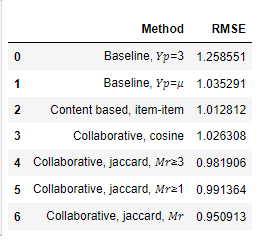

In [167]:
print('Average rating of the test data:', data.test.rating.mean())

Average rating of the test data: 3.5815078833444978


In [164]:
print('Average rating of the test data predictions:', predictions_test.mean())

Average rating of the test data predictions: 1.0742451533703798


In [170]:
Sparsity = (R.toarray() == 0). sum() / (R.shape[0] * R.shape[1])
print('Sparsity of rating matrix:', Sparsity)

Sparsity of rating matrix: 0.9701829421165106


The NMF model is significantly underpredicting ratings.

Why is this the case? Our rating data is sparse. The degree of sparsity is 97%. When many entries in the matrix are zero, NMF may struggle to accurately capture the patterns and relationships present.

Perhaps we can do better using another matrix factorization technique. We will try to predict test ratings using scipy's Singular Value Decomposition.

In theory, unlike NMF, which enforces non-negativity in its factorized matrices, SVD allows both positive and negative values. This flexibility can be advantageous when dealing with sparse data, where negative values might capture important relationships that non-negativity constraints would disregard.

### SVD

First, we will concatenate both the train and test data, then calculate the mean for each user before subtracting these means from their respective user ratings. We can then obtain the train and test data with the additional column of mean-centered ratings.

We then create a user-movie rating matrix on the training ratings data, before performing SVD on this rating matrix.

In [63]:
all_data = pd.concat([train, test], ignore_index=True)

In [64]:
def ids_encoder(data):
    """
    Create label encoder for userId and movieId
    Encode ratings.userId and ratings.movieId
    """
    users = sorted(data['uID'].unique())
    items = sorted(data['mID'].unique())

    # create users encoder (uencoder) and movies/items encoder
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and movies ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    # encode userids and itemids
    data.uID = uencoder.transform(data.uID.tolist())
    data.mID = iencoder.transform(data.mID.tolist())

    return uencoder, iencoder, data

In [66]:
uencoder, iencoder, all_data = ids_encoder(all_data)

In [70]:
def mean_centered(data):
    users_mean = data.groupby('uID', as_index=False)['rating'].mean()
    
    norm_ratings = pd.merge(data, users_mean, suffixes=('', '_mean'), on='uID')
    
    norm_ratings['mean_centered_rating'] = norm_ratings['rating'] - norm_ratings['rating_mean']
    
    return users_mean.to_numpy()[:, 1], norm_ratings

In [71]:
users_mean, all_data_norm = mean_centered(all_data)

In [73]:
train_norm = all_data_norm.loc[:len(train)-1, :]
test_norm = all_data_norm.loc[len(train):, :]

In [139]:
train_norm

,uID,mID,rating,rating_mean,mean_centered_rating
0,743,1120,5,3.370370,1.629630
1,743,2334,5,3.370370,1.629630
2,743,2263,3,3.370370,-0.370370
3,743,2170,4,3.370370,0.629630
4,743,279,5,3.370370,1.629630
...,...,...,...,...,...
700141,2763,240,4,4.186441,-0.186441
700142,2763,865,5,4.186441,0.813559
700143,2763,515,4,4.186441,-0.186441
700144,2763,892,5,4.186441,0.813559


In [85]:
def rating_matrix(train_norm):
    """
    Create a Rating Matrix, where rating data comes from the train set 
    of shape (#alluser, #allmovies)
    :return: A sparse rating matrix of COOrdinate format
    """
    allusers = list(MV_users.uID.unique())
    allmovies = list(MV_movies.mID.unique())
    ind_movie = train_norm.mID
    ind_user = train_norm.uID
    rating_train = list(train_norm.mean_centered_rating)
        
    return coo_matrix((rating_train, (ind_user, ind_movie)), shape=(len(allusers), len(allmovies)))

In [86]:
R = rating_matrix(train_norm)

In [89]:
U, Sigma, Vt = svd(R.toarray())

In [156]:
cumulative_variance = np.cumsum(Sigma**2) / np.sum(Sigma**2)

# Choose k for 90% variance
k = np.argmax(cumulative_variance >= 0.9)
k

831

In [104]:
# Let's first pick k=50 and see how well we do in predicting rating
k = 50
U_k = U[:, :k]
Sigma_k = np.diag(Sigma[:k])
Vt_k = Vt[:k, :]

# predict ratings
predicted_ratings = np.dot(np.dot(U_k, Sigma_k), Vt_k)

In [110]:
# add back users mean
predicted_ratings += users_mean[:, np.newaxis]

In [112]:
pd.DataFrame(predicted_ratings)

,0,1,2,3,4,5,6,7,8,9,...,3873,3874,3875,3876,3877,3878,3879,3880,3881,3882
0,4.350046,4.200705,4.200182,4.181103,4.193318,4.183230,4.197476,4.187345,4.186231,4.169450,...,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679
1,3.807934,3.629949,3.731585,3.701650,3.738556,3.710919,3.708811,3.694906,3.683258,3.672734,...,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178
2,3.888985,3.856119,3.959039,3.906841,3.908460,3.886208,3.918535,3.907788,3.906719,3.915360,...,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961
3,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,...,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476
4,3.090564,3.091286,3.235956,3.135109,3.115828,3.141923,3.101408,3.168866,3.195577,3.113108,...,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,3.804298,2.946290,3.410571,3.305363,3.412838,3.087947,3.256424,3.274968,3.225203,3.018805,...,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928
6036,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,...,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822
6037,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,...,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000
6038,3.878049,3.878049,3.878049,3.878049,3.878049,3.878049,3.878049,3.878049,3.878049,3.878049,...,3.878049,3.878049,3.878049,3.878049,3.878049,3.878049,3.878049,3.878049,3.878049,3.878049


In [133]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))
    

def predict(uid, mid):
    user_idx = uencoder.transform([uid])[0]
    movie_idx = iencoder.transform([mid])[0]
    r_hat = predicted_ratings[user_idx, movie_idx]
    return r_hat
    

def predict_all(test):
    test_predictions = []
    for i in range(len(test)):
        uid = test.uID[i]
        mid = test.mID[i]
        r_hat = predict(uid, mid)
        test_predictions.append(r_hat)   
    return np.array(test_predictions)

In [132]:
test_predictions = predict_all(test)

In [136]:
y_true = np.array(test.rating)

In [138]:
rmse(y_true, test_predictions)

0.8857163186311773

The SVD technique performs significantly better than Non-Negative Matrix Factorization on our sparse data.